In [1]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

def load_single(oid_filename, feature_filename):
    oid     = np.memmap(oid_filename, mode='c', dtype=np.uint64)
    feature = np.memmap(feature_filename, mode='c', dtype=np.float32).reshape(oid.shape[0], -1)
    return oid, feature


#np.random.seed(666)

# Plot config

In [4]:
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams["font.size"] = 22
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.2

xtick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
ytick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
plt.rc('xtick', **xtick_param)
plt.rc('ytick', **ytick_param)

grid_param = {'linestyle': '--', 'alpha': 0.5}
plt.rc('grid', **grid_param)

# load data

In [10]:
features_path = '/media/snad/data/features/snad4_art'
oids, features_art = load_single(f'{features_path}/sid_snad4_r_100.dat', f'{features_path}/feature_snad4_r_100.dat')

In [4]:
import onnxruntime as rt


def load_rbmodel(model_name):
    """
    Load real-bogus model
    Input: object features
    Output: probability that an object is artefact
    """
    sess = rt.InferenceSession(model_name, providers=["CPUExecutionProvider"])
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    prob_name = sess.get_outputs()[1].name
    return (sess, input_name, label_name, prob_name)

def pred_from_onnx(model, data, return_label=False):
    """Prediction from onnx session"""
    session, input_name, label_name, prob_name = model
    if return_label:
        pred_label = session.run([label_name], {input_name: np.array(data).astype(np.float32)})[0]
    pred_proba = session.run([prob_name], {input_name: np.array(data).astype(np.float32)})[0]
    pred_proba = np.float32([pred[1] for pred in pred_proba])
    return (pred_proba, pred_label) if return_label else pred_proba



In [5]:
akb_data = pd.read_csv('akb_obj_features_snad4.csv')
akb_features = np.array(akb_data.iloc[:, 2:])

model = load_rbmodel('RBclf_snad4.onnx')
predict = pred_from_onnx(model, akb_features)

akb_data['rb_score'] = predict

In [6]:
t = time.monotonic()
sub_sample = features_art[np.random.randint(0, features_art.shape[0], size=2000000)]
t = (time.monotonic() - t) / 60
print(f'Sub sampling in {t:.0f} m')

Sub sampling in 0 m


In [7]:
def get_z_vectors(sample, akb, n_estimators=100, rs=666):
    t = time.monotonic()
    iforest = IsolationForest(random_state=rs, n_jobs=20, n_estimators=n_estimators).fit(sample)
    t = (time.monotonic() - t) / 60
    print(f'Isolation forest fitted in {t:.0f} m')
    
    trees = iforest.estimators_
    z_vectors = []
    node_to_leaf = [{} for i in range(len(trees))]
    leafs_count = np.zeros(len(trees))
    for i, tree in enumerate(trees):
        nodes = tree.apply(akb)
        n_leafs = tree.get_n_leaves()
        leafs = []
        for node in nodes:
            if node not in node_to_leaf[i] and n_leafs > leafs_count[i]:
                node_to_leaf[i][node] = leafs_count[i]
                leafs_count[i] += 1
            elif n_leafs <= leafs_count[i] and node not in node_to_leaf[i]:
                print('ERROR: LEAVES NUMBER LESS THAN EXPECTED')
            leafs.append(node_to_leaf[i][node])
        leafs = np.array(leafs, dtype=int)
    
        onehot = np.zeros((leafs.size, n_leafs))
        onehot[np.arange(leafs.size), leafs] = 1
        z_vectors.append(onehot)
    z_vectors = np.hstack(z_vectors)
    return z_vectors, iforest

In [8]:
def calc_acc(z_vectors):
    acc = np.zeros(z_vectors.shape[1])
    for i in range(z_vectors.shape[1]):
        acc[i] = np.sum(z_vectors[:, i] == akb_data.iloc[:, 1]) / z_vectors.shape[0]
    
    return acc

# SNAD4 features

In [1]:
akb_snad4 = np.array(akb_data.iloc[:, 2:-1])
n_trees = 100
rs = 42
z_vec_snad4, _ = get_z_vectors(sub_sample[:, :54], akb_snad4, n_estimators=n_trees, rs=rs)

NameError: name 'np' is not defined

--------------
accuracy

In [118]:
acc_snad4 = calc_acc(z_vec_snad4)
print(f'snad4 accuracy\nmean = {np.mean(acc_snad4):.3f}     std = {np.std(acc_snad4):.3f}')

snad4 accuracy
mean = 0.503     std = 0.021


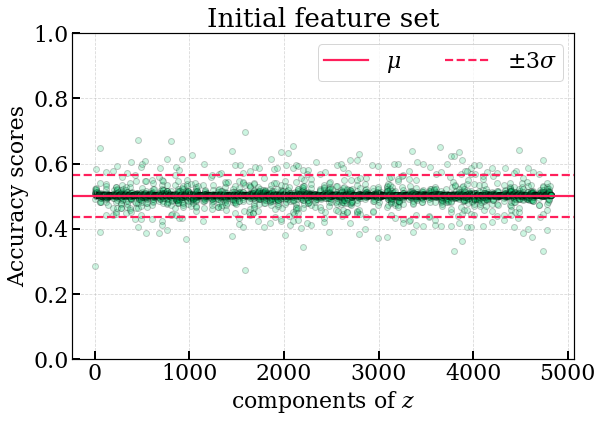

In [119]:
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(np.arange(len(acc_snad4)), acc_snad4, color=u'#00CD6C', alpha=0.2, edgecolors='black')#u'#00CD6C'  u'#009ADE'  u'#FFC61E'  u'#AF58BA'
plt.axhline(y=0.5, color=u'#FF1F5B', linestyle='-', label=r'$\mu$')
plt.axhline(y=0.5+3*np.std(acc_snad4), color=u'#FF1F5B', linestyle='--', alpha=1)
plt.axhline(y=0.5-3*np.std(acc_snad4), color=u'#FF1F5B', linestyle='--', alpha=1, label=r'$\pm3\sigma$')
plt.xlabel('components of $z$')
plt.ylabel('Accuracy scores')
plt.title('Initial feature set')
plt.ylim(0,1)
ax.grid('on')
#ax.text(500, 0.9, f'number of trees: {n_trees}')
plt.legend(ncol=2, borderpad=0.3)
#plt.savefig('plots/snad4/onehot_acc_snad4_bigfont.pdf', dpi=400, format='pdf', bbox_inches="tight")

------------
------------

# SNAD4 + r/b score

In [120]:
akb_snad4_art = np.array(akb_data.iloc[:, 2:])
z_vec_snad4_art, _ = get_z_vectors(sub_sample, akb_snad4_art, n_estimators=n_trees, rs=rs)

Isolation forest fitted in 0 m


---------------
Accuracy

In [121]:
acc_snad4_art = calc_acc(z_vec_snad4_art)
print(f'snad4_art accuracy\nmean = {np.mean(acc_snad4_art):.3f}     std = {np.std(acc_snad4_art):.3f}')

snad4_art accuracy
mean = 0.503     std = 0.026


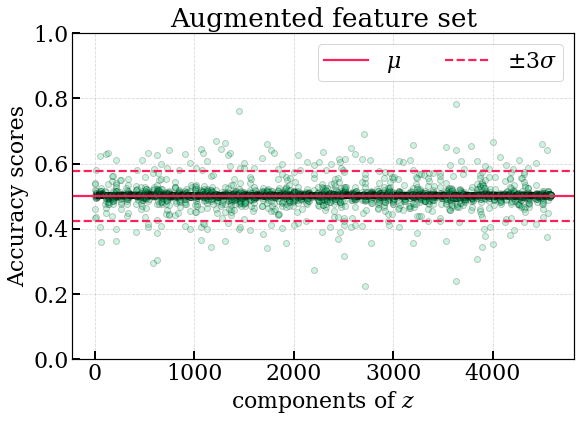

In [122]:
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(np.arange(len(acc_snad4_art)), acc_snad4_art, color=u'#00CD6C', alpha=0.2, edgecolors='black')
plt.axhline(y=0.5, color=u'#FF1F5B', linestyle='-', label=r'$\mu$')
plt.axhline(y=0.5+3*np.std(acc_snad4_art), color=u'#FF1F5B', linestyle='--', alpha=1)
plt.axhline(y=0.5-3*np.std(acc_snad4_art), color=u'#FF1F5B', linestyle='--', alpha=1, label=r'$\pm3\sigma$')
plt.xlabel('components of $z$')
plt.ylabel('Accuracy scores')
plt.title('Augmented feature set')
plt.ylim(0,1)
ax.grid('on')
plt.legend(ncol=2, borderpad=0.3)
#plt.savefig('plots/snad4/onehot_acc_snad4_art_bigfont.pdf', dpi=400, format='pdf', bbox_inches="tight")

---------------
---------------

---
# Forest from coniferest

In [1]:
from coniferest.isoforest import IsolationForest
from coniferest.aadforest import AADForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


def load_single(oid_filename, feature_filename):
    oid     = np.memmap(oid_filename, mode='c', dtype=np.uint64)
    feature = np.memmap(feature_filename, mode='c', dtype=np.float32).reshape(oid.shape[0], -1)
    return oid, feature


# Plot config

In [2]:
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams["font.size"] = 22
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.2

xtick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
ytick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
plt.rc('xtick', **xtick_param)
plt.rc('ytick', **ytick_param)

grid_param = {'linestyle': '--', 'alpha': 0.5}
plt.rc('grid', **grid_param)

In [3]:
features_path = '/media/snad/data/features/snad4_art'
oids, features_art = load_single(f'{features_path}/sid_snad4_r_100.dat', f'{features_path}/feature_snad4_r_100.dat')

In [4]:
import onnxruntime as rt


def load_rbmodel(model_name):
    """
    Load real-bogus model
    Input: object features
    Output: probability that an object is artefact
    """
    sess = rt.InferenceSession(model_name, providers=["CPUExecutionProvider"])
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    prob_name = sess.get_outputs()[1].name
    return (sess, input_name, label_name, prob_name)

def pred_from_onnx(model, data, return_label=False):
    """Prediction from onnx session"""
    session, input_name, label_name, prob_name = model
    if return_label:
        pred_label = session.run([label_name], {input_name: np.array(data).astype(np.float32)})[0]
    pred_proba = session.run([prob_name], {input_name: np.array(data).astype(np.float32)})[0]
    pred_proba = np.float32([pred[1] for pred in pred_proba])
    return (pred_proba, pred_label) if return_label else pred_proba



In [5]:
akb_data = pd.read_csv('akb_obj_features_snad4.csv')
akb_features = np.array(akb_data.iloc[:, 2:])

model = load_rbmodel('RBclf_snad4.onnx')
predict = pred_from_onnx(model, akb_features)

akb_data['rb_score'] = predict

In [6]:
def get_z_vectors(sample, akb, n_estimators=100, rs=666):
    t = time.monotonic()
    iforest = IsolationForest(random_seed=rs, n_jobs=20, n_trees=n_estimators).fit(sample)
    t = (time.monotonic() - t) / 60
    print(f'Forest fitted in {t:.0f} m')
    
    x_leafs = iforest.apply(akb)
    z_vectors = np.zeros((x_leafs.shape[0], x_leafs.max() + 1))
    for i in range(len(z_vectors)):
        z_vectors[i][x_leafs[i]] = np.ones(len(z_vectors[i][x_leafs[i]]))
        
    return z_vectors, iforest

In [7]:
def calc_acc(z_vectors):
    acc = np.zeros(z_vectors.shape[1])
    for i in range(z_vectors.shape[1]):
        acc[i] = np.sum(z_vectors[:, i] == akb_data.iloc[:, 1]) / z_vectors.shape[0]
    
    return acc

# SNAD4 features

In [20]:
akb_snad4 = np.array(akb_data.iloc[:, 2:-1])
n_trees = 100
rs = 100
z_vec_snad4, _ = get_z_vectors(features_art[:, :54], akb_snad4, n_estimators=n_trees, rs=rs)

Forest fitted in 0 m


--------------
accuracy

In [21]:
acc_snad4 = calc_acc(z_vec_snad4)
print(f'snad4 accuracy\nmean = {np.mean(acc_snad4):.3f}     std = {np.std(acc_snad4):.3f}')

snad4 accuracy
mean = 0.503     std = 0.024


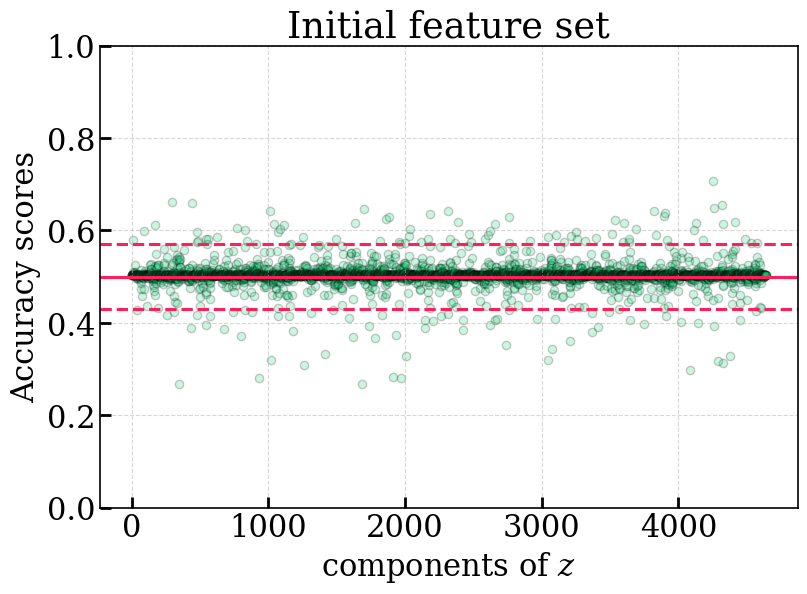

In [22]:
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(np.arange(len(acc_snad4)), acc_snad4, color=u'#00CD6C', alpha=0.2, edgecolors='black')#u'#00CD6C'  u'#009ADE'  u'#FFC61E'  u'#AF58BA'
plt.axhline(y=0.5, color=u'#FF1F5B', linestyle='-', label=r'$\mu$')
plt.axhline(y=0.5+3*np.std(acc_snad4), color=u'#FF1F5B', linestyle='--', alpha=1)
plt.axhline(y=0.5-3*np.std(acc_snad4), color=u'#FF1F5B', linestyle='--', alpha=1, label=r'$\pm3\sigma$')
plt.xlabel('components of $z$')
plt.ylabel('Accuracy scores')
plt.title('Initial feature set')
plt.ylim(0,1)
ax.grid('on')
#ax.text(500, 0.9, f'number of trees: {n_trees}')
#plt.legend(ncol=2, borderpad=0.3)
#plt.savefig('plots/snad4/onehot_acc_snad4_bigfont.pdf', dpi=400, format='pdf', bbox_inches="tight")

# SNAD4 + r/b score

In [23]:
akb_snad4_art = np.array(akb_data.iloc[:, 2:])
z_vec_snad4_art, _ = get_z_vectors(features_art, akb_snad4_art, n_estimators=n_trees, rs=rs)

Forest fitted in 0 m


---------------
Accuracy

In [24]:
acc_snad4_art = calc_acc(z_vec_snad4_art)
print(f'snad4_art accuracy\nmean = {np.mean(acc_snad4_art):.3f}     std = {np.std(acc_snad4_art):.3f}')

snad4_art accuracy
mean = 0.503     std = 0.026


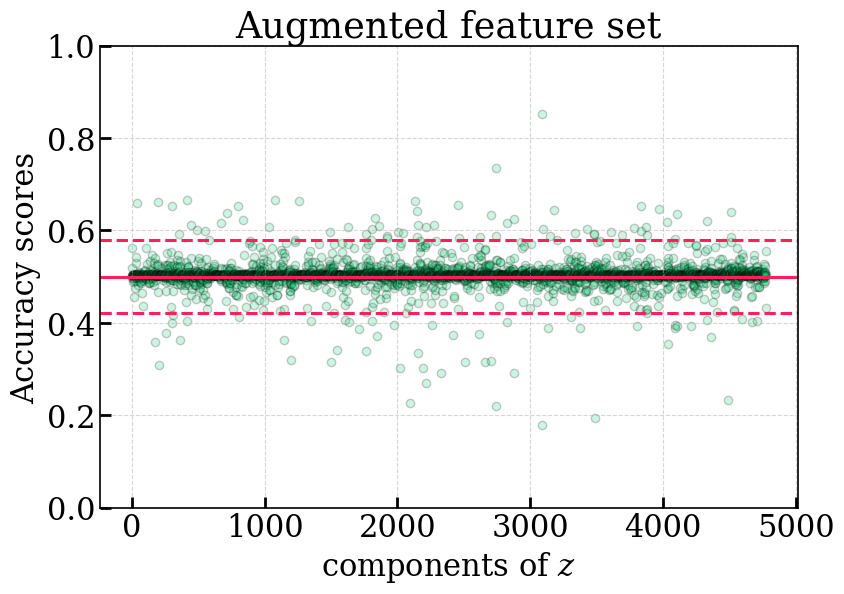

In [25]:
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(np.arange(len(acc_snad4_art)), acc_snad4_art, color=u'#00CD6C', alpha=0.2, edgecolors='black')
plt.axhline(y=0.5, color=u'#FF1F5B', linestyle='-', label=r'$\mu$')
plt.axhline(y=0.5+3*np.std(acc_snad4_art), color=u'#FF1F5B', linestyle='--', alpha=1)
plt.axhline(y=0.5-3*np.std(acc_snad4_art), color=u'#FF1F5B', linestyle='--', alpha=1, label=r'$\pm3\sigma$')
plt.xlabel('components of $z$')
plt.ylabel('Accuracy scores')
plt.title('Augmented feature set')
plt.ylim(0,1)
ax.grid('on')
#plt.legend(ncol=2, borderpad=0.3)
#plt.savefig('plots/snad4/onehot_acc_snad4_art_bigfont.pdf', dpi=400, format='pdf', bbox_inches="tight")